In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import pickle
import scipy.io as spio
import scipy.stats as sp
import mat73
import seaborn as sns
from scipy.special import factorial
from scipy.special import logsumexp
import pandas as pd
from replay_structure.utils import get_marginal_sum

In [2]:
from replay_structure.structure_trajectory import Most_Likely_Trajectories
import replay_structure.structure_models as models

In [3]:
import replay_structure.structure_models_gridsearch as gridsearch
from replay_structure.config import (
    Structure_Model_Gridsearch_Parameters)
from replay_structure.model_comparison import (
    Gridsearch_Marginalization,
    Model_Comparison,
)

In [34]:
pd.set_option('display.max_rows', None)

In [4]:
%load_ext autoreload
%autoreload 2

## load data

In [141]:
bin_size_cm=5
time_window_ms=15

In [142]:
DATA_PATH = "/home/masha/Documents/Studium/MIT/project/data_test"
filename = DATA_PATH+'/structure_analysis_input/ripple_spikemat_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'

RESULTS_PATH = "/home/masha/Documents/Studium/MIT/project/1D/results_test/"
d_gs_result = RESULTS_PATH+'ripple_marginalized_gridsearch_diffusion_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'
mc = RESULTS_PATH+'ripple_model_comparison_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'

In [143]:
with open(filename, "rb") as file_object:
    raw_data = file_object.read()
    structure_data = pickle.loads(raw_data)

In [21]:
with open(d_gs_result, "rb") as file_object:
    raw_data = file_object.read()
    diffusion_result = pickle.loads(raw_data)

In [16]:
with open(mc, "rb") as file_object:
    raw_data = file_object.read()
    model_comparison = pickle.loads(raw_data)

In [125]:
model_comparison.results_dataframe.head()

,diffusion,momentum,stationary,stationary_gaussian,random,mll_model
0,-41.552481,-42.345086,-42.085101,-41.401338,-42.421778,stationary_gaussian
1,-57.927742,-58.035193,-57.853174,-58.165446,-61.612448,stationary
2,-126.740406,-124.917018,-167.520693,-138.219128,-135.141291,momentum
3,-45.091940,-44.404269,-45.954521,-45.548904,-48.749530,momentum
4,-41.708810,-41.790453,-41.534081,-41.790942,-42.813049,stationary


## get trajectories

In [129]:
# get index of replay classified ripples
traj_indx = np.where(model_comparison.results_dataframe["mll_model"].isin(['momentum', 'diffusion']))[0]
# get ripple indices that are not classified
nan_indx = np.where(model_comparison.results_dataframe["mll_model"].isna())[0]
# correct index when inserting
correction = list(range(0,len(nan_indx)))

In [130]:
sd_meters = diffusion_result.marginalization_info['best_fit_gridsearch_params']['sd_meters']
sd_meters_ = np.insert(sd_meters, nan_indx-correction, np.nan)

In [133]:
diff_params_dict = dict(zip(traj_indx, sd_meters_[traj_indx]))

In [135]:
trajectory_dict = dict()
marginal_dict = dict()
for ind in traj_indx:
    trajectory = Most_Likely_Trajectories(structure_data, sd_meters_[ind], False).get_most_likely_trajectory(structure_data, ind)
    trajectory_dict[ind] = trajectory
    marginal = models.Diffusion(structure_data, sd_meters_[ind]).get_spikemat_marginals(ind)
    marginal_dict[ind] = marginal

/home/masha/Documents/Studium/MIT/project/1D/replay_structure/viterbi.py:38: RuntimeWarning: divide by zero encountered in log
  np.log(self.params["transition_matrix"][:, :]) + omegas[t - 1]


In [136]:
trajectory_result_dict = dict(zip(['sd_meters_best_fit', 'most_likely_trajectory', 'marginal'], [diff_params_dict, trajectory_dict, marginal_dict]))

## plot trajectories

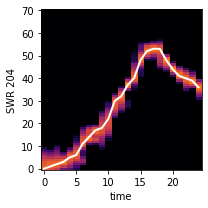

In [140]:
ripple_index=204
marginal_plot = get_marginal_sum(trajectory_result_dict['marginal'][ripple_index])

plt.figure(figsize=(3,3))
plt.imshow(marginal_plot,aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4),interpolation='none')
plt.plot(trajectory_result_dict['most_likely_trajectory'][ripple_index], c="white", lw="2")

plt.xlabel('time')
plt.ylabel('SWR '+str(ripple_index))

plt.tight_layout()
#plt.savefig('fig/traj169', dpi=500, transparent=True)